# STR Adaptativo Indirecto

Incluye parte no adaptativa y parte adaptativa indirecta y directa con identificación RLS.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
import math
import sympy as sp

## Planta a controlar y especificaciones

Obtener un controlador STR para el sistema de primer orden descripto por la transferencia

$$G(s)=\frac{1}{s(s+1)}$$

Se desea seguimiento a un modelo de segundo orden de frecuencia=1 rad/s, coeficiente de amortiguamiento 0.7, y ganancia de continua unitaria 
Considerar Ts=0.5s

In [ ]:
# Especificación del modelo
# parámetros
wn = 1.0         # rad/s (natural frequency)
zeta = 0.7       # damping
Ts = 0.5         # periodo de muestreo

# Motor. Sistema continuo
s = ctrl.TransferFunction.s
K = 1.0
tau = 1.0
G = K / s / (tau * s + 1)

# Discretización
Gd = ctrl.c2d(G, Ts, method='zoh')
Gd.name = 'Planta'
print(f'Sistema discretizado: {Gd}')

# polos continuos
p1 = -zeta*wn + 1j*wn*math.sqrt(1 - zeta**2)
p2 = -zeta*wn - 1j*wn*math.sqrt(1 - zeta**2)

# polos discretos (mapeo exacto s -> z)
z1 = np.exp(p1 * Ts)
z2 = np.exp(p2 * Ts)

# Armo el modelo a seguir
Am = np.poly([z1, z2])              
Bm = np.polymul([1,0],[np.sum(Am)])

# Selección del modelo a seguir: tiene d0=1 (igual a la planta) y pide cancelar un cero de la planta de los que no es bueno andar cancelando
#Bm = [0.1761, 0]
#Am = [1, -1.3205, 0.4966]
Gm = ctrl.TransferFunction(Bm,Am,dt=Ts)
Gm.name='Modelo'
print(f'Ganancia de continua = {np.sum(Bm)/np.sum(Am)}')
print('Modelo a seguir',Gm)

Ganancia de continua = 1.0
Modelo a seguir <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

        0.1761 z
  ---------------------
  z^2 - 1.32 z + 0.4966
Sistema discretizado: <TransferFunction>: Planta
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.1065 z + 0.0902
  ----------------------
  z^2 - 1.607 z + 0.6065


## Implementación del STR adaptativo indirecto 

Con cancelación y resolviendo la Diofantina en forma analítica.

No resulta útil la resolución numérica pensando en una implementación en un controlador real, sobre todo por la carga computacional.

Por lo tanto se resuelve en forma analítica y se expresan los coeficientes del controlador en función de los parámetros de la planta y las condiciones de diseño a fin de simplificar la implementación de una estructura adaptativa indirecta.

In [9]:
# Variable del polinomio
z = sp.symbols('z')

# Modelo de la planta (queda expresado en función de los parámetros que luego se identifican)
a1, a2, b0, b1 = sp.symbols('a1 a2 b0 b1')
A = z**2 + a1*z + a2
B = b0*z + b1

# Polinomios deseados (vamos con cancelación porque el cero de B no aparece en Bm)
am1, am2, bm0 = sp.symbols('am1 am2 bm0')
Bm = bm0*z
Am = z**2 + am1*z + am2

# Factorizamos B
B_mas = z + b1/b0
B_menos = b0

Bm_bar = Bm/B_menos 

# Por compatibilidad resulta que el grado de Ac es 3, Am tiene grado 2 y además tengo que considerar que hay un polo que cancela B_mas, por lo que Ao es grado 0
Ao = 1
# Además dim(R) = dim(S) = dim(T) = 1
# Como R = R_bar * B_mas => dim(R_bar)=0; Como R tiene que ser monico => R_bar = 1
R_bar = 1
r1, s0, s1, t0, t1 = sp.symbols('r1 s0 s1 t0 t1')
R = z + r1
S = s0 *z + s1
T = t0 *z + t1

# Planteo la ec Diofantina y obtengo s0 y s1
def resolver_polinomio(poli,vec_vars,z=sp.symbols('z')):
    eq = sp.expand(poli)
    poly_eq = sp.Poly(eq, z)
    coeff_eqs = [sp.Eq(c, 0) for c in poly_eq.all_coeffs()]
    sol = sp.solve(coeff_eqs, vec_vars, dict=True)
    if len(sol) == 0:
        raise ValueError("No se encontró solución simbólica.")
    return sol[0]

S_dict = resolver_polinomio(A * R_bar + B_menos * S - Ao * Am, [s0,s1], z)
print(S_dict)

# Obtengo r1
R_dict = resolver_polinomio(R_bar * B_mas - R, [r1], z)
print(R_dict)

# Obtengo t0 y t1
T_dict = resolver_polinomio(Ao*Bm_bar-T, [t0,t1], z)
print(T_dict)

# Genero las funciones lambda para usar en el ciclo del controlador
def build_lambda_from_mixed_dict(sol_dict, params_syms):
    """
    Construye lambdas numéricas R_fun, S_fun, T_fun a partir de un diccionario combinado:
      ej. {r1: expr, s0: expr, s1: expr, t0: expr}
    
    params_syms: lista o tupla de símbolos (ej. [a1, a2, b0, b1, am1, am2, bm0])
    """
    def extract_group(prefix):
        group_items = [(str(k), v) for k, v in sol_dict.items() if str(k).startswith(prefix)]
        if not group_items:
            return []
        group_items = sorted(group_items, key=lambda kv: int(kv[0].replace(prefix, '')))
        return [expr for _, expr in group_items]
    
    # extraer expresiones por grupo
    R_exprs = extract_group('r')
    S_exprs = extract_group('s')
    T_exprs = extract_group('t')

    # crear lambdas solo si el grupo existe
    R_fun = sp.lambdify(params_syms, [1] + R_exprs, 'numpy') if R_exprs else None
    S_fun = sp.lambdify(params_syms, S_exprs, 'numpy') if S_exprs else None
    T_fun = sp.lambdify(params_syms, T_exprs, 'numpy') if T_exprs else None

    return S_fun, T_fun, R_fun

# construir las funciones lambda
S_fun, T_fun, R_fun = build_lambda_from_mixed_dict(S_dict | R_dict | T_dict, [a1,a2,b0,b1,am1,am2,bm0])

# evaluar con valores numéricos para el ejercicio en particular 
# ATENCION: los parámetros tienen este orden: a1,a2,b0,b1,am1,am2,bm0
vals = ( -1.6065, 0.6065, 0.1065, 0.0902, -1.3205, 0.4966,0.1761 )

S_val = S_fun(*vals)
R_val = R_fun(*vals)
T_val = T_fun(*vals)

print("S =", S_val)
print("T =", T_val)
print("R =", R_val)


{s0: (-a1 + am1)/b0, s1: (-a2 + am2)/b0}
{r1: b1/b0}
{t0: bm0/b0, t1: 0}
S = [2.685446009389672, -1.0319248826291085]
T = [1.6535211267605634, 0]
R = [1, 0.8469483568075118]


/tmp/ipykernel_2437226/3543970554.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


-96


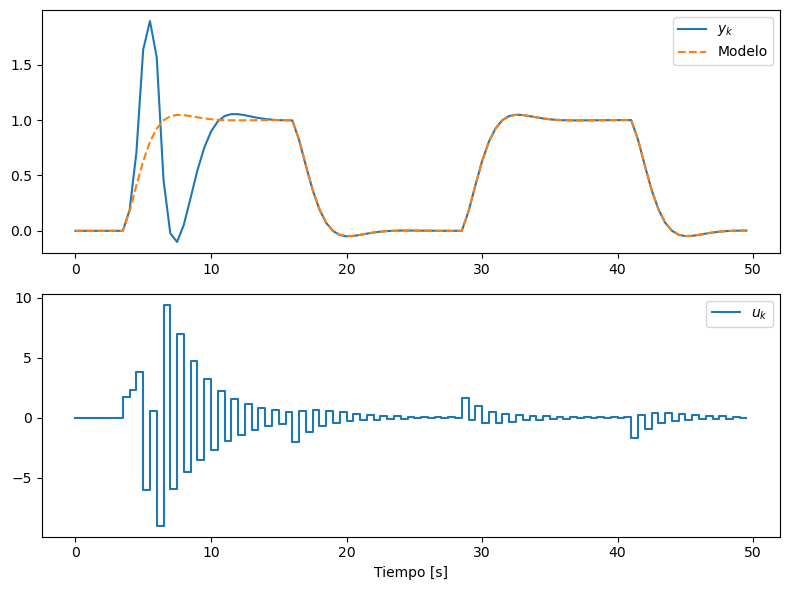

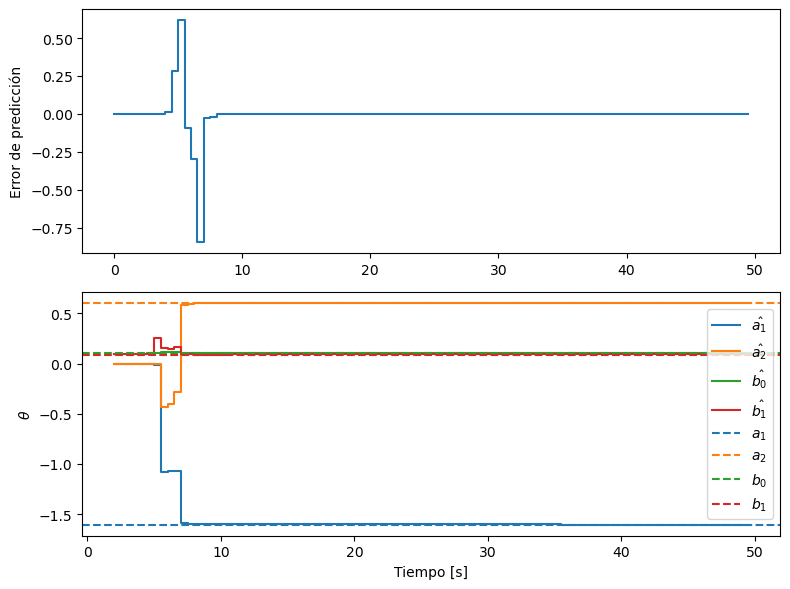

In [10]:
def simular_STR_indirecto(G,Gm,S_fun,T_fun,R_fun,t_final,Ts=0.5,sigma_v=0.1):
    # --- Simulación ---
    t = np.arange(0, t_final, Ts)
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    v = sigma_v*np.random.randn(n_steps)
    #v = sigma_v*np.ones(n_steps)
    y = np.zeros(n_steps)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros(n_steps)

    lambda_ = 0.95
    na = 2
    nb = 2

    theta_hat = np.zeros(na+nb)
    theta_hat[-1] = 0.1
    theta_hat[-2] = 0.1
    P = 100 * np.eye(na+nb)          # matriz de incertidumbre grande
    theta_hist = []    
    theta_real = [-1.6065, 0.6065, 0.1065, 0.0902]

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(3, n_steps-1):
        # y[k] = salida actual
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

        vals = ( theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3], -1.3205, 0.4966,0.1761 )

        # Ajusto el controlador en función de la identificación actual
        S = S_fun(*vals)
        R = R_fun(*vals)
        T = T_fun(*vals)

        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Calculo la evolución de y usando el modelo de la planta discretizada
        #y[k+1] = (np.dot(B,u[k:k-len(B):-1]) - np.dot(A[1:], y[k:k+1-len(A):-1]))/A[0]

        # Simular dinámica continua con entrada u[k]
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1]  # tomar valor al final del período


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()


    theta_hist = np.array(theta_hist)
    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    #plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de predicción')
    plt.subplot(212)
    print(-len(theta_hist))
    for idx_na in range(0,na):        
        plt.step(t[-len(theta_hist):],theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
    for idx_nb in range(0,nb):
        plt.step(t[-len(theta_hist):],theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb}}}$",where='post')

    if theta_real!=None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for idx_na in range(na):
            color = colors[idx_na % len(colors)]
            plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na+1}$")
        for idx_nb in range(nb):
            color = colors[(idx_nb+na) % len(colors)]
            plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


simular_STR_indirecto(G,Gm,S_fun,T_fun,R_fun,50,Ts,sigma_v=0)

## STR adaptativo indirecto sin cancelación

{r1: (a1*b1**2 - a2*b0*b1 + am1*ao*b0*b1 - am1*b1**2 - am2*ao*b0**2 + am2*b0*b1 - ao*b1**2)/(a1*b0*b1 - a2*b0**2 - b1**2), s0: (-a1**2*b1 + a1*a2*b0 + a1*am1*b1 + a1*ao*b1 - a2*am1*b0 - a2*ao*b0 + a2*b1 - am1*ao*b1 + am2*ao*b0 - am2*b1)/(a1*b0*b1 - a2*b0**2 - b1**2), s1: (-a1*a2*b1 + a1*am2*ao*b0 + a2**2*b0 - a2*am1*ao*b0 + a2*am1*b1 - a2*am2*b0 + a2*ao*b1 - am2*ao*b1)/(a1*b0*b1 - a2*b0**2 - b1**2)}
{t0: (am1 + am2 + 1)/(b0 + b1), t1: (am1*ao + am2*ao + ao)/(b0 + b1)}
S = [1.642282047708725, -0.7470100599100461]
T = [0.8952719877986779, 0.0]
R = [1, 0.11109696191902099]


/tmp/ipykernel_2437226/3543970554.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


-96


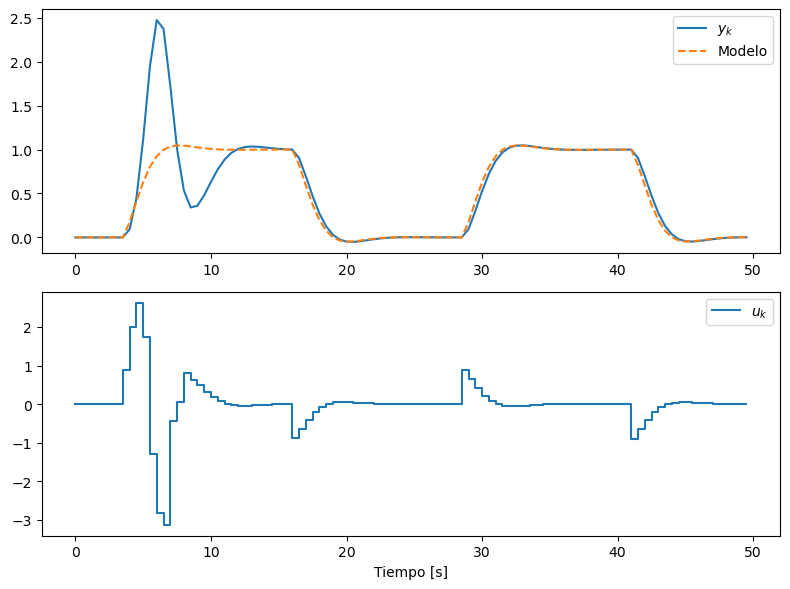

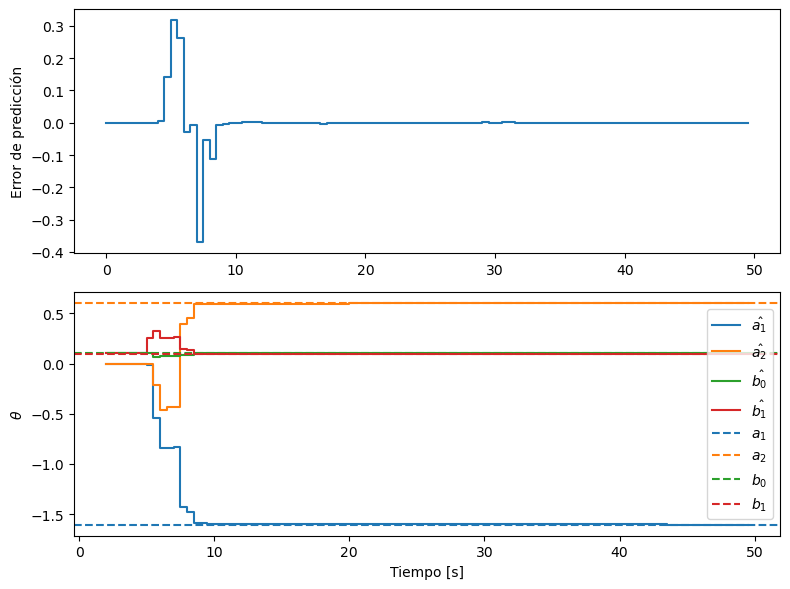

In [11]:
# Modelo de la planta (queda expresado en función de los parámetros que luego se identifican)
a1, a2, b0, b1 = sp.symbols('a1 a2 b0 b1')
A = z**2 + a1*z + a2
B = b0*z + b1

# Polinomios deseados (vamos sin cancelación porque el cero de B aparece en Bm)
# Ajusto los coefs de Bm para que la ganancia sea unitaria 
am1, am2 = sp.symbols('am1 am2')
Bm = (b0*z + b1)*(1+am1+am2)/(b0+b1)
Am = z**2 + am1*z + am2

# Factorizamos B
B_mas = 1 
B_menos = b0*z + b1

Bm_bar = sp.simplify(Bm/B_menos)

# Por compatibilidad resulta que el grado de Ac es 3, Am tiene grado 2 y por lo que Ao es grado 1
ao = sp.symbols('ao')
Ao = z + ao
# Además dim(R) = dim(S) = dim(T) = 1
# Como R = R_bar * B_mas => dim(R_bar)=1; Como R tiene que ser monico => R_bar = R
r1, s0, s1, t0, t1 = sp.symbols('r1 s0 s1 t0 t1')
R = z + r1
S = s0 *z + s1
T = t0 *z + t1

# Planteo la ec Diofantina y obtengo s0 y s1
SR_dict = resolver_polinomio(A * R + B * S - Ao * Am, [s0,s1,r1], z)
print(SR_dict)

# Obtengo t0 y t1
T_dict = resolver_polinomio(Ao*Bm_bar-T, [t0,t1], z)
print(T_dict)



# construir las funciones lambda
S_fun, T_fun, R_fun = build_lambda_from_mixed_dict(SR_dict | T_dict, [a1,a2,b0,b1,am1,am2,ao])

# evaluar con valores numéricos para el ejercicio en particular 
# ATENCION: los parámetros tienen este orden: a1,a2,b0,b1,am1,am2, ao
vals = ( -1.6065, 0.6065, 0.1065, 0.0902, -1.3205, 0.4966, 0  )

S_val = S_fun(*vals)
R_val = R_fun(*vals)
T_val = T_fun(*vals)

print("S =", S_val)
print("T =", T_val)
print("R =", R_val)

simular_STR_indirecto(G,Gm,S_fun,T_fun,R_fun,50,Ts,sigma_v=0.0)